In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import sys
import math
#import timm

import numpy as np


import torch
import torch.nn as  nn

def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


def patch_first_conv(model, new_in_channels, default_in_channels=3, pretrained=True):

    for module in model.modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == default_in_channels:
            break

    weight = module.weight.detach()
    module.in_channels = new_in_channels

    if not pretrained:
        module.weight = nn.parameter.Parameter( torch.Tensor(module.out_channels,
                         new_in_channels // module.groups, *module.kernel_size))
        module.reset_parameters()

    elif new_in_channels == 1:
        new_weight = weight.sum(1, keepdim=True)
        module.weight = nn.parameter.Parameter(new_weight)

    else:
        new_weight = torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)

        for i in range(new_in_channels):
            new_weight[:, i] = weight[:, i % default_in_channels]

        new_weight = new_weight * (default_in_channels / new_in_channels)
        module.weight = nn.parameter.Parameter(new_weight)


def replace_strides_with_dilation(module, dilation_rate):

    for mod in module.modules():
        if isinstance(mod, nn.Conv2d):
            mod.stride = (1, 1)
            mod.dilation = (dilation_rate, dilation_rate)
            kh, kw = mod.kernel_size
            mod.padding = ((kh // 2) * dilation_rate, (kh // 2) * dilation_rate)

            if hasattr(mod, "static_padding"):
                mod.static_padding = nn.Identity()


class EncoderMixin:

    _output_stride = 32


    @property
    def out_channels(self):
        return self._out_channels[: self._depth + 1]

    @property
    def output_stride(self):
        return min(self._output_stride, 2 ** self._depth)

    def set_in_channels(self, in_channels, pretrained=True):
        if in_channels == 3:
            return

        self._in_channels = in_channels
        if self._out_channels[0] == 3:
            self._out_channels = tuple([in_channels] + list(self._out_channels)[1:])

        patch_first_conv(model=self, new_in_channels=in_channels, pretrained=pretrained)

    def get_stages(self):
        raise NotImplementedError

    def make_dilated(self, output_stride):

        if output_stride == 16:
            stage_list = [
                5,
            ]
            dilation_list = [
                2,
            ]

        elif output_stride == 8:
            stage_list = [4, 5]
            dilation_list = [2, 4]

        else:
            raise ValueError("Output stride should be 16 or 8, got {}.".format(output_stride))

        self._output_stride = output_stride

        stages = self.get_stages()
        for stage_indx, dilation_rate in zip(stage_list, dilation_list):
            replace_strides_with_dilation(
                module=stages[stage_indx],
                dilation_rate=dilation_rate,)


class TimmUniversalEncoder(nn.Module):
    def __init__(self, name, pretrained=True, in_channels=3, depth=5, output_stride=32):
        super().__init__()
        kwargs = dict( in_chans=in_channels,   features_only=True,  output_stride=output_stride,
            pretrained=pretrained,   out_indices=tuple(range(depth)), )

        if output_stride == 32:
            kwargs.pop("output_stride")

        self.model = timm.create_model(name, **kwargs)
        self._in_channels = in_channels
        self._out_channels = [in_channels,] + self.model.feature_info.channels()
        self._depth = depth
        self._output_stride = output_stride

    def forward(self, x):
        features = self.model(x)
        features = [ x, ] + features
        return features

    @property
    def out_channels(self):
        return self._out_channels

    @property
    def output_stride(self):
        return min(self._output_stride, 2 ** self._depth)

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00


In [ ]:
import os
import sys
import math

import numpy as np

import torch
import torch.nn as  nn


#from .utils import EncoderMixin
from timm.models.resnet import ResNet
from timm.models.resnet import Bottleneck



class ResNestEncoder(ResNet, EncoderMixin):
    def __init__(self, out_channels, depth=5, **kwargs):
        super().__init__(**kwargs)
        self._depth = depth
        self._out_channels = out_channels
        self._in_channels = 3

        del self.fc
        del self.global_pool

    def get_stages(self):

        return [
            nn.Identity(), nn.Sequential(self.conv1, self.bn1, self.act1),
            nn.Sequential(self.maxpool, self.layer1), self.layer2, self.layer3, self.layer4
        ]

    def make_dilated(self, *args, **kwargs):
        raise ValueError("ResNest encoders do not support dilated mode")

    def forward(self, x):
        stages = self.get_stages()
        features = [ ]

        for i in range(self._depth + 1):
            x = stages[i](x)
            features.append(x)
        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("fc.bias", None)
        state_dict.pop("fc.weight", None)
        super().load_state_dict(state_dict, **kwargs)


resnest_weights = {
    "timm-resnest14d": {
        "imagenet": "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest14-9c8fe254.pth",  # noqa
    },
    "timm-resnest26d": {
        "imagenet": "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth",  # noqa
    },
    "timm-resnest50d": {
        "imagenet": "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth",  # noqa
    },
    "timm-resnest101e": {
        "imagenet": "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest101-22405ba7.pth",  # noqa
    },
    "timm-resnest200e": {
        "imagenet": "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest200-75117900.pth",  # noqa
    },
    "timm-resnest269e": {
        "imagenet": "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest269-0cc87c48.pth",  # noqa
    },
    "timm-resnest50d_4s2x40d": {
        "imagenet": "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50_fast_4s2x40d-41d14ed0.pth",  # noqa
    },
    "timm-resnest50d_1s4x24d": {
        "imagenet": "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50_fast_1s4x24d-d4a4f76f.pth",  # noqa
    },
}


pretrained_settings = {}
for model_name, sources in resnest_weights.items():
    pretrained_settings[model_name] = {}
    for source_name, source_url in sources.items():
        pretrained_settings[model_name][source_name] = {
            "url": source_url,
            "input_size": [3, 224, 224],
            "input_range": [0, 1],
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
            "num_classes": 1000,
        }


timm_resnest_encoders = {
    "timm-resnest14d": {
        "encoder": ResNestEncoder,
        "pretrained_settings": pretrained_settings["timm-resnest14d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [1, 1, 1, 1],
            "stem_type": "deep",
            "stem_width": 32,
            "avg_down": True,
            "base_width": 64,
            "cardinality": 1,
            "block_args": {"radix": 2, "avd": True, "avd_first": False},
        },
    },

    "timm-resnest26d": {
        "encoder": ResNestEncoder,
        "pretrained_settings": pretrained_settings["timm-resnest26d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [2, 2, 2, 2],
            "stem_type": "deep",
            "stem_width": 32,
            "avg_down": True,
            "base_width": 64,
            "cardinality": 1,
            "block_args": {"radix": 2, "avd": True, "avd_first": False},
        },
    },

    "timm-resnest50d": {
        "encoder": ResNestEncoder,
        "pretrained_settings": pretrained_settings["timm-resnest50d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 6, 3],
            "stem_type": "deep",
            "stem_width": 32,
            "avg_down": True,
            "base_width": 64,
            "cardinality": 1,
            "block_args": {"radix": 2, "avd": True, "avd_first": False},
        },
    },

    "timm-resnest101e": {
        "encoder": ResNestEncoder,
        "pretrained_settings": pretrained_settings["timm-resnest101e"],
        "params": {
            "out_channels": (3, 128, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 23, 3],
            "stem_type": "deep",
            "stem_width": 64,
            "avg_down": True,
            "base_width": 64,
            "cardinality": 1,
            "block_args": {"radix": 2, "avd": True, "avd_first": False},
        },
    },

     "timm-resnest200e": {
        "encoder": ResNestEncoder,
        "pretrained_settings": pretrained_settings["timm-resnest200e"],
        "params": {
            "out_channels": (3, 128, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 24, 36, 3],
            "stem_type": "deep",
            "stem_width": 64,
            "avg_down": True,
            "base_width": 64,
            "cardinality": 1,
            "block_args": {"radix": 2, "avd": True, "avd_first": False},
        },
    },

    "timm-resnest269e": {
        "encoder": ResNestEncoder,
        "pretrained_settings": pretrained_settings["timm-resnest269e"],
        "params": {
            "out_channels": (3, 128, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 30, 48, 8],
            "stem_type": "deep",
            "stem_width": 64,
            "avg_down": True,
            "base_width": 64,
            "cardinality": 1,
            "block_args": {"radix": 2, "avd": True, "avd_first": False},
        },
    },

    "timm-resnest50d_4s2x40d": {
        "encoder": ResNestEncoder,
        "pretrained_settings": pretrained_settings["timm-resnest50d_4s2x40d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 6, 3],
            "stem_type": "deep",
            "stem_width": 32,
            "avg_down": True,
            "base_width": 40,
            "cardinality": 2,
            "block_args": {"radix": 4, "avd": True, "avd_first": True},
        },
    },

    "timm-resnest50d_1s4x24d": {
        "encoder": ResNestEncoder,
        "pretrained_settings": pretrained_settings["timm-resnest50d_1s4x24d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 6, 3],
            "stem_type": "deep",
            "stem_width": 32,
            "avg_down": True,
            "base_width": 24,
            "cardinality": 4,
            "block_args": {"radix": 1, "avd": True, "avd_first": True},
        },
    },
}

In [ ]:
import os
import sys
import math

import numpy as np

from copy import deepcopy

import torch
import torch.nn as nn

from torchvision.models.resnet import ResNet
from torchvision.models.resnet import Bottleneck
from torchvision.models.resnet import BasicBlock
#from pretrainedmodels.models.torchvision_models import pretrained_settings

#from .utils import EncoderMixin


class ResNetEncoder(ResNet, EncoderMixin):
    def __init__(self, out_channels, depth=5, **kwargs):
        super().__init__(**kwargs)

        self._depth = depth
        self._out_channels = out_channels
        self._in_channels = 3

        del self.fc
        del self.avgpool

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self.conv1, self.bn1, self.relu),
            nn.Sequential(self.maxpool, self.layer1),
            self.layer2,
            self.layer3,
            self.layer4,
        ]

    def forward(self, x):
        stages = self.get_stages()

        features = [ ]
        for i in range(self._depth + 1):
            x = stages[i](x)
            features.append(x)
        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("fc.bias", None)
        state_dict.pop("fc.weight", None)
        super().load_state_dict(state_dict, **kwargs)



new_settings = {
    "resnet18": {
        "ssl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnet18-d92f0530.pth",  # noqa
        "swsl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnet18-118f1556.pth",  # noqa
    },

    "resnet50": {
        "ssl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnet50-08389792.pth",  # noqa
        "swsl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnet50-16a12f1b.pth",  # noqa
    },

     "resnext50_32x4d": {
        "imagenet": "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth",
        "ssl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext50_32x4-ddb3e555.pth",  # noqa
        "swsl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext50_32x4-72679e44.pth",  # noqa
    },
    "resnext101_32x4d": {
        "ssl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext101_32x4-dc43570a.pth",  # noqa
        "swsl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext101_32x4-3f87e46b.pth",  # noqa
    },
    "resnext101_32x8d": {
        "imagenet": "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth",
        "instagram": "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth",
        "ssl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext101_32x8-2cfe2f8b.pth",  # noqa
        "swsl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext101_32x8-b4712904.pth",  # noqa
    },
    "resnext101_32x16d": {
        "instagram": "https://download.pytorch.org/models/ig_resnext101_32x16-c6f796b0.pth",
        "ssl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext101_32x16-15fffa57.pth",  # noqa
        "swsl": "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_weakly_supervised_resnext101_32x16-f3559a9c.pth",  # noqa
    },
    "resnext101_32x32d": {
        "instagram": "https://download.pytorch.org/models/ig_resnext101_32x32-e4b90b00.pth",
    },
    "resnext101_32x48d": {
        "instagram": "https://download.pytorch.org/models/ig_resnext101_32x48-3e41cc8a.pth",
    },
}


pretrained_settings = deepcopy(pretrained_settings)

for model_name, sources in new_settings.items():
    if model_name not in pretrained_settings:
        pretrained_settings[model_name] = {}

    for source_name, source_url in sources.items():
        pretrained_settings[model_name][source_name] = {
            "url": source_url,
            "input_size": [3, 224, 224],
            "input_range": [0, 1],
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
            "num_classes": 1000,
        }

resnet_encoders = {
    "resnet18": {
        "encoder": ResNetEncoder,
        "pretrained_settings": pretrained_settings["resnet18"],
        "params": {
            "out_channels": (3, 64, 64, 128, 256, 512),
            "block": BasicBlock,
            "layers": [2, 2, 2, 2],
        },
    },
    #"resnet34": {
        #"encoder": ResNetEncoder,
        #"pretrained_settings": pretrained_settings["resnet34"],
        #"params": {
            #"out_channels": (3, 64, 64, 128, 256, 512),
            #"block": BasicBlock,
            #"layers": [3, 4, 6, 3],
        #},
    #},
    "resnet50": {
        "encoder": ResNetEncoder,
        "pretrained_settings": pretrained_settings["resnet50"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 6, 3],
        },
    },
    #"resnet101": {
        #"encoder": ResNetEncoder,
        #"pretrained_settings": pretrained_settings["resnet101"],
        #"params": {
            #"out_channels": (3, 64, 256, 512, 1024, 2048),
            #"block": Bottleneck,
            #"layers": [3, 4, 23, 3],
        #},
    #},
    #"resnet152": {
        #"encoder": ResNetEncoder,
        #"pretrained_settings": pretrained_settings["resnet152"],
        #"params": {
            #"out_channels": (3, 64, 256, 512, 1024, 2048),
            #"block": Bottleneck,
            #"layers": [3, 8, 36, 3],
        #},
    #},
    "resnext50_32x4d": {
        "encoder": ResNetEncoder,
        "pretrained_settings": pretrained_settings["resnext50_32x4d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 6, 3],
            "groups": 32,
            "width_per_group": 4,
        },
    },
    "resnext101_32x4d": {
        "encoder": ResNetEncoder,
        "pretrained_settings": pretrained_settings["resnext101_32x4d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 23, 3],
            "groups": 32,
            "width_per_group": 4,
        },
    },
    "resnext101_32x8d": {
        "encoder": ResNetEncoder,
        "pretrained_settings": pretrained_settings["resnext101_32x8d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 23, 3],
            "groups": 32,
            "width_per_group": 8,
        },
    },
    "resnext101_32x16d": {
        "encoder": ResNetEncoder,
        "pretrained_settings": pretrained_settings["resnext101_32x16d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 23, 3],
            "groups": 32,
            "width_per_group": 16,
        },
    },
    "resnext101_32x32d": {
        "encoder": ResNetEncoder,
        "pretrained_settings": pretrained_settings["resnext101_32x32d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 23, 3],
            "groups": 32,
            "width_per_group": 32,
        },
    },
    "resnext101_32x48d": {
        "encoder": ResNetEncoder,
        "pretrained_settings": pretrained_settings["resnext101_32x48d"],
        "params": {
            "out_channels": (3, 64, 256, 512, 1024, 2048),
            "block": Bottleneck,
            "layers": [3, 4, 23, 3],
            "groups": 32,
            "width_per_group": 48,
        },
    },
}

In [ ]:

import os
import sys
import math
import time
import functools


import numpy as np

import torch.utils.model_zoo as model_zoo

#from .resnet import resnet_encoders
#from .utils import preprocess_input, TimmUniversalEncoder
#from .timm_resnet import timm_resnest_encoders


encoders = {}
encoders.update(resnet_encoders)

def get_encoder(name, in_channels=3, depth=5, weights=None, output_stride=32, **kwargs):

    try:
        Encoder = encoders[name]["encoder"]
    except KeyError:
        raise KeyError("Wrong encoder name `{}`, supported encoders: {}".format(name, list(encoders.keys())))

    params = encoders[name]["params"]
    params.update(depth=depth)
    encoder = Encoder(**params)

    if weights is not None:
        try:
            settings = encoders[name]["pretrained_settings"][weights]

        except KeyError:
            raise KeyError(
                "Wrong pretrained weights `{}` for encoder `{}`. Available options are: {}".format(
                    weights,
                    name,
                    list(encoders[name]["pretrained_settings"].keys()),
                )
            )
        encoder.load_state_dict(model_zoo.load_url(settings["url"]))

    encoder.set_in_channels(in_channels, pretrained=weights is not None)

    if output_stride != 32:
        encoder.make_dilated(output_stride)

    return encoder


def get_encoder_names():
    return list(encoders.keys())


def get_preprocessing_params(encoder_name, pretrained="imagenet"):

    all_settings = encoders[encoder_name]["pretrained_settings"]
    if pretrained not in all_settings.keys():
        raise ValueError("Available pretrained options {}".format(all_settings.keys()))

    settings = all_settings[pretrained]

    formatted_settings = {}
    formatted_settings["input_space"] = settings.get("input_space", "RGB")
    formatted_settings["input_range"] = list(settings.get("input_range", [0, 1]))
    formatted_settings["mean"] = list(settings.get("mean"))
    formatted_settings["std"] = list(settings.get("std"))

    return formatted_settings


def get_preprocessing_fn(encoder_name, pretrained="imagenet"):
    params = get_preprocessing_params(encoder_name, pretrained=pretrained)
    return functools.partial(preprocess_input, **params)

In [ ]:
#image augmentation
import torchvision.transforms as transforms
mean=0.5
std_deviation=0.5

CHANNELS_IMG=3
transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([mean for _ in range(CHANNELS_IMG)],[std_deviation for _ in range(CHANNELS_IMG)]),

     ]
)

In [ ]:
import os
import sys
import math

import cv2
import glob
import random

import numpy as np

import torch
import torch.utils.data as data


class BrainTumorDataset(data.Dataset):
    def __init__(self, datafolder='/content/gdrive/MyDrive/train_new', transforms = transforms, train=True,
                        image_size=(640, 640), train_test_ratio=0.15, preprocessing_fun=None):
        super().__init__()

        self.train = train
        self.transform = transforms
        self.image_size = image_size
        self.train_test_ratio = train_test_ratio
        self.preprocessing_fun = preprocessing_fun

        image_names = [ ]
        image_names_jpg = glob.glob(os.path.join(datafolder, '*.jpg'))
        image_names_jpeg = glob.glob(os.path.join(datafolder, '*.jpeg'))
        image_names_png  = glob.glob(os.path.join(datafolder, '*.png'))
        image_names.extend(image_names_jpg)
        image_names.extend(image_names_jpeg)
        image_names.extend(image_names_png)

        Num_testSamples = int(train_test_ratio*len(image_names))
        random.seed(42)
        random.shuffle(image_names)

        if self.train:
            self.image_names = image_names[Num_testSamples:]
        else:
            self.image_names = image_names[:Num_testSamples]

    def __len__(self):
        return len(self.image_names)

    def read_image(self, image_name):
        img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
        try:
            Img = cv2.resize(img, self.image_size, cv2.INTER_CUBIC)
            Img = 255.0*(Img/ Img.max())
            return Img
        except:
            raise ValueError('Image not found')

    def add_rice_noise(self, img, snr=10, mu=0.1, sigma=1):
        level = snr* np.max(img) / 100
        size = img.shape
        x = level* np.random.normal(mu, sigma, size=size) + img
        y = level * np.random.normal(mu, sigma, size=size)
        return np.sqrt(x**2 + y**2).astype(np.int16)

    def __getitem__(self, index):

        image_name = self.image_names[index]
        Img = self.read_image(image_name)
        Img_noisy = self.add_rice_noise(Img)

        Img_noisy = np.stack([Img_noisy, Img_noisy, Img_noisy], axis=-1)
        Img = np.expand_dims(Img, axis=-1)


        Img = torch.from_numpy(Img).to(torch.float32)
        Img_noisy = torch.from_numpy(Img_noisy).to(torch.float32)

        Img = Img/ Img.max()
        Img_noisy = (Img_noisy - Img_noisy.min()) / (Img_noisy.max() - Img_noisy.min())
        if self.preprocessing_fun:
            Img_noisy = self.preprocessing_fun(Img_noisy)

        Img_noisy = Img_noisy.permute(2, 0, 1)
        Img = Img.permute(2, 0, 1)
        return Img_noisy, Img




if __name__ == '__main__':
    #from encoder.encoder_model import get_preprocessing_fn
    encoder_name = 'resnet18'
    preprocessing =  get_preprocessing_fn(encoder_name=encoder_name, pretrained='ssl')
    dataset = BrainTumorDataset(preprocessing_fun=preprocessing)
    print(len(dataset))
    Img_noisy, Img = dataset[0]
    print(Img_noisy.shape, Img.shape, Img_noisy.max(), Img.max(), Img_noisy.min(), Img.min())

    #cv2.imshow('noisy image', np.uint8(255*Img_noisy.numpy().transpose(1, 2, 0)[:,:, 0]))
    #cv2.imshow('ground image', np.uint8(255*Img.numpy().transpose(1, 2, 0)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

433
torch.Size([3, 640, 640]) torch.Size([1, 640, 640]) tensor(2.6400, dtype=torch.float64) tensor(1.) tensor(-2.1179, dtype=torch.float64) tensor(0.)


In [ ]:
import os
import sys
import math

import numpy as np

import torch
import torch.nn as nn

def initialize_decoder(module):
    for m in module.modules():

        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


def initialize_head(module):
    for m in module.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [ ]:
import os
import sys
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    from inplace_abn import InPlaceABN
except ImportError:
    InPlaceABN = None

class Conv2dReLU(nn.Sequential):
    def __init__( self,   in_channels,   out_channels, kernel_size, padding=0,   stride=1,   use_batchnorm=True, ):
        conv = nn.Conv2d(in_channels,   out_channels,  kernel_size,
                  stride=stride,   padding=padding,  bias=not (use_batchnorm), )

        relu = nn.ReLU(inplace=True)
        if use_batchnorm:
            bn = nn.BatchNorm2d(out_channels)
        else:
            bn = nn.Identity()
        super(Conv2dReLU, self).__init__(conv, bn, relu)


class SCSEModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels//reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels//reduction, in_channels, 1),
            nn.Sigmoid()
        )

        self.sSE =  nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)


class DecoderBlock(nn.Module):
    def __init__( self,  in_channels,  skip_channels,  out_channels,  use_batchnorm=True):
        super().__init__()

        self.conv1 = Conv2dReLU( in_channels + skip_channels, out_channels, kernel_size=3, padding=1,
                                 use_batchnorm=use_batchnorm, )

        self.attention1 = SCSEModule(in_channels=in_channels + skip_channels)
        self.conv2 = Conv2dReLU( out_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm,)
        self.attention2 = SCSEModule( in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class UnetDecoder(nn.Module):
    def __init__( self, encoder_channels, decoder_channels, n_blocks=5, use_batchnorm=True,):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError("Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)))

        encoder_channels = encoder_channels[1:]
        encoder_channels = encoder_channels[::-1]

        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        blocks = [ DecoderBlock(in_ch, skip_ch, out_ch, use_batchnorm=use_batchnorm)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]
        features = features[::-1]
        x = features[0]
        skips = features[1:]

        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)
        return x


#if __name__ == '__main__':
    #model = UnetDecoder()

In [ ]:
import os
import sys
import math


import numpy as np

from typing import List

import torch
import torch.nn as nn

#from encoder.encoder_model import get_encoder
#from modules import UnetDecoder
#from initialization import initialize_decoder, initialize_head


class OutputLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, activation=None):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        super().__init__(conv2d)




class UNeT(nn.Module):
    def __init__(self, encoder_name: str = "resnet18",  encoder_depth: int = 5,in_channels: int = 3,
                   decoder_channels: List[int] = (256, 128, 64, 32, 16),):
        super().__init__()

        self.encoder = get_encoder(encoder_name, in_channels=in_channels, depth=encoder_depth)
        self.decoder = UnetDecoder(self.encoder.out_channels, decoder_channels=decoder_channels, n_blocks= encoder_depth)
        self.output  = OutputLayer(decoder_channels[-1], out_channels=1)
        self.iniitialize()

    def check_input_shape(self, x):
        h, w = x.shape[-2:]
        output_stride = self.encoder.output_stride
        if h % output_stride != 0 or w % output_stride != 0:
            new_h = (h // output_stride + 1) * output_stride if h % output_stride != 0 else h
            new_w = (w // output_stride + 1) * output_stride if w % output_stride != 0 else w
            raise RuntimeError(f"Wrong input shape height={h}, width={w}. Expected image height and width "
                f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w}).")

    def iniitialize(self):
        initialize_decoder(self.decoder)
        initialize_head(self.output)

    def forward(self, x):
        self.check_input_shape(x)
        features = self.encoder(x)
        decoder_output = self.decoder(*features)
        output = self.output(decoder_output)
        return output

if __name__ == '__main__':
    model  =UNeT()
    #print(model)

    x = torch.randn(1, 3, 224, 224)
    out = model(x)
    #print(out.shape)

In [ ]:
# !pip install torchview

In [ ]:
# from torchview import draw_graph
# import graphviz

# # when running on VSCode run the below command
# # svg format on vscode does not give desired result
# graphviz.set_jupyter_format('png')
# model_graph = draw_graph(model, input_size=(32,3,640,640), device='meta',expand_nested=False)
# model_graph.visual_graph

In [ ]:
import os
import sys
import math

import cv2

import numpy as np


import torch
import torch.nn as nn

import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = [ ]
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())

        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False

        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input_image, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input_image.shape[1] != 3:
            input_image = input_image.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)

        input_image = (input_image - self.mean) / self.std
        target = (target - self.mean) / self.std
        if self.resize:
            input_image = self.transform(input_image, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)

        loss = 0.0
        x = input_image
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)

            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)

        return loss

In [ ]:
import torch
import math
import torch.nn.functional as F
import numpy as np


def gaussian(window_size, sigma):
    gauss = torch.Tensor(
        [
            math.exp(-((x - window_size // 2) ** 2) / float(2 * sigma ** 2))
            for x in range(window_size)
        ]
    )
    return gauss / gauss.sum()


def create_window(window_size, channel=1):

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float()
    _2D_window /= _2D_window.sum()
    _2D_window = _2D_window.unsqueeze(0).unsqueeze(0)

    window = torch.Tensor(
        _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    )

    return window


def ssim(
    img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range  # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2

    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None:
        real_size = min(window_size, height, width)  # window should be atleast 11x11
        window = create_window(real_size, channel=channels).to(img1.device)

    # calculating the mu parameter (locally) for both images using a gaussian filter
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability
    C1 = (0.01) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03) ** 2

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean()
    else:
        ret = ssim_score.mean(1).mean(1).mean(1)

    if full:
        return ret, contrast_metric

    return ret

In [ ]:
import cv2
import torch
import torch.nn.functional as F

def calculate_psnr(image1, image2):

    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")


    device1 = torch.device('cpu')
    image1 = image1.to(device1)
    image2 = image2.to(device1)
    # Calculate (MSE)
    mse = F.mse_loss(image1.float(), image2.float()).item()

    # Calculate the maximum pixel value
    max_pixel = torch.max(image1.float())

    # Calculate the PSNR value
    psnr = 10 * torch.log10((max_pixel ** 2) / mse)

    return psnr



In [ ]:
import os
import sys
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision


def save_model(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)

def load_checkpoint(checkpoint_path, model, model_opt):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model_opt.optimizer.load_state_dict(checkpoint['optimizer'])
    return model, model_opt, checkpoint['epoch']


def save_figure(model, loader, epoch, device, mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]):
    model.eval()

    if not os.path.exists(os.path.join(os.getcwd(), 'save_results')):
        os.mkdir(os.path.join(os.getcwd(), 'save_results'))

    result_dir = os.path.join(os.getcwd(), 'save_results')
    if not os.path.exists(os.path.join(result_dir, str(epoch))):
        os.mkdir(os.path.join(result_dir, str(epoch)))

    save_dir = os.path.join(result_dir, str(epoch))
    for idx, (x, y) in enumerate(loader):
        x = x.to(device).float()
        with torch.no_grad():
            out = torch.sigmoid(model(x))
            torchvision.utils.save_image(out[2,:], f"{save_dir}/pred_{idx}.png")
            torchvision.utils.save_image(y[2,:],  f"{save_dir}/target_{idx}.png")
            x = x.permute(0, 2, 3, 1).cpu().numpy()
            x = (x *np.array(std)) + np.array(mean)
            x = x / x.max()
            x = np.transpose(x, (0, 3, 1, 2))
            x = torch.from_numpy(x).float().to(device)
            torchvision.utils.save_image(x[2,:], f"{save_dir}/pnoisy_{idx}.png")
        break


In [ ]:
import os
import sys
import math

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#from ssim import ssim
#from PerceptualLoss import  VGGPerceptualLoss

criterion = VGGPerceptualLoss()

def train(model, loader, optimizer, device, ):

    model.train()
    training_loss = 0.0
    avg_ssim = 0.0
    criterion = VGGPerceptualLoss()
    avg_psnr=0.0

    for i ,(x, y) in tqdm(enumerate(loader), total=len(loader), leave=False):

        x = x.to(device).float()
        y = y.to(device).float()
        criterion = criterion.to(device)

        out = torch.sigmoid(model(x))
        optimizer.zero_grad()

        # metrics = ssim(out, y, 1)
        # metrics2=calculate_psnr(out,y)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        # avg_ssim += metrics.item()
        # avg_psnr+=metrics2

    training_loss = training_loss / len(loader)
    # avg_ssim      = avg_ssim / len(loader)
    # avg_psnr = avg_psnr/len(loader)
    return model, training_loss, avg_ssim,avg_psnr


def evaluate(model, loader, device):
    model.eval()
    val_loss = 0.0
    avg_ssim = 0.0
    avg_psnr=0.0
    criterion = VGGPerceptualLoss()

    with torch.no_grad():
        for i ,(x, y) in tqdm(enumerate(loader), total=len(loader), leave=False):

            x = x.to(device).float()
            y = y.to(device).float()
            criterion = criterion.to(device)

            out = model(x)
            out = torch.sigmoid(out)

            metrics = ssim(out, y, 1)
            metrics2=calculate_psnr(out,y)
            loss = criterion(out, y)


            val_loss      += loss.item()
            avg_ssim      += metrics.item()
            avg_psnr+=metrics2

        val_loss = val_loss / len(loader)
        avg_ssim = avg_ssim / len(loader)
        avg_psnr = avg_psnr/len(loader)
        return model, val_loss, avg_ssim,avg_psnr

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 41.0MB/s]


433 76
55 10


epoch 0 Training loss 1.9164997816085816 training ssim 0.0 training psnr 0.0                   validation loss 2.671071743965149 and testing ssim 0.19175611436367035 testing_psnr 3.361661434173584


epoch 1 Training loss 1.6002556584098122 training ssim 0.0 training psnr 0.0                   validation loss 1.5102197170257567 and testing ssim 0.43548665642738343 testing_psnr 12.531476020812988


epoch 2 Training loss 1.4498348062688655 training ssim 0.0 training psnr 0.0                   validation loss 1.5234755158424378 and testing ssim 0.6815564930438995 testing_psnr 19.201953887939453


epoch 3 Training loss 1.3296704010529952 training ssim 0.0 training psnr 0.0                   validation loss 1.5401189804077149 and testing ssim 0.7015475392341614 testing_psnr 12.30384635925293


epoch 4 Training loss 1.2126917080445723 training ssim 0.0 training psnr 0.0                   validation loss 1.18134286403656 and testing ssim 0.8429835736751556 testing_psnr 30.337627410888672


epoch 5 Training loss 1.1758254701440984 training ssim 0.0 training psnr 0.0                   validation loss 1.1852007746696471 and testing ssim 0.8343759417533875 testing_psnr 29.739639282226562


epoch 6 Training loss 1.1589943734082309 training ssim 0.0 training psnr 0.0                   validation loss 1.1722100496292114 and testing ssim 0.8393115222454071 testing_psnr 28.5677433013916


epoch 7 Training loss 1.146575893055309 training ssim 0.0 training psnr 0.0                   validation loss 1.1331689476966857 and testing ssim 0.8599086582660675 testing_psnr 27.827251434326172


epoch 8 Training loss 1.1356224016709762 training ssim 0.0 training psnr 0.0                   validation loss 1.1333695650100708 and testing ssim 0.849591052532196 testing_psnr 28.81329345703125


epoch 9 Training loss 1.128442627733404 training ssim 0.0 training psnr 0.0                   validation loss 1.1556755900382996 and testing ssim 0.853864973783493 testing_psnr 22.41476058959961


epoch 10 Training loss 1.13030452078039 training ssim 0.0 training psnr 0.0                   validation loss 1.111140251159668 and testing ssim 0.8750343382358551 testing_psnr 30.442800521850586


epoch 11 Training loss 1.1268538193269209 training ssim 0.0 training psnr 0.0                   validation loss 1.1399505853652954 and testing ssim 0.869911390542984 testing_psnr 24.447711944580078


epoch 12 Training loss 1.1090115677226673 training ssim 0.0 training psnr 0.0                   validation loss 1.1099905252456665 and testing ssim 0.8803780496120452 testing_psnr 29.672115325927734


epoch 13 Training loss 1.1055316491560503 training ssim 0.0 training psnr 0.0                   validation loss 1.1365548372268677 and testing ssim 0.8695714473724365 testing_psnr 24.084339141845703


epoch 14 Training loss 1.1010761239311913 training ssim 0.0 training psnr 0.0                   validation loss 1.1339321374893188 and testing ssim 0.8386745452880859 testing_psnr 31.67820167541504


epoch 15 Training loss 1.0933701385151255 training ssim 0.0 training psnr 0.0                   validation loss 1.1019372582435607 and testing ssim 0.8787555038928986 testing_psnr 31.798797607421875


epoch 16 Training loss 1.0924328457225452 training ssim 0.0 training psnr 0.0                   validation loss 1.0866251349449159 and testing ssim 0.8909843683242797 testing_psnr 30.767629623413086


epoch 17 Training loss 1.085430872440338 training ssim 0.0 training psnr 0.0                   validation loss 1.0791723489761353 and testing ssim 0.8909716308116913 testing_psnr 31.240489959716797


epoch 18 Training loss 1.076842561635104 training ssim 0.0 training psnr 0.0                   validation loss 1.0892799019813537 and testing ssim 0.8963308990001678 testing_psnr 32.54130554199219


epoch 19 Training loss 1.0675961125980724 training ssim 0.0 training psnr 0.0                   validation loss 1.0757130980491638 and testing ssim 0.8919422626495361 testing_psnr 29.649362564086914


epoch 20 Training loss 1.071490770036524 training ssim 0.0 training psnr 0.0                   validation loss 1.0640599846839904 and testing ssim 0.9004649639129638 testing_psnr 31.687158584594727


epoch 21 Training loss 1.0674367536198008 training ssim 0.0 training psnr 0.0                   validation loss 1.0789148211479187 and testing ssim 0.8778611660003662 testing_psnr 32.173362731933594


epoch 22 Training loss 1.0561635819348423 training ssim 0.0 training psnr 0.0                   validation loss 1.0739826917648316 and testing ssim 0.896808260679245 testing_psnr 32.945621490478516


epoch 23 Training loss 1.0691005966880105 training ssim 0.0 training psnr 0.0                   validation loss 1.058215892314911 and testing ssim 0.9020622491836547 testing_psnr 32.063148498535156


epoch 24 Training loss 1.0607420964674517 training ssim 0.0 training psnr 0.0                   validation loss 1.0668768525123595 and testing ssim 0.8970088183879852 testing_psnr 30.872142791748047


epoch 25 Training loss 1.0544050444256177 training ssim 0.0 training psnr 0.0                   validation loss 1.0665918111801147 and testing ssim 0.9036054134368896 testing_psnr 31.217121124267578


epoch 26 Training loss 1.0505900101228194 training ssim 0.0 training psnr 0.0                   validation loss 1.0622804045677186 and testing ssim 0.8978386282920837 testing_psnr 31.54034996032715


epoch 27 Training loss 1.0449575445868753 training ssim 0.0 training psnr 0.0                   validation loss 1.0458007097244262 and testing ssim 0.9040452659130096 testing_psnr 32.80711364746094


epoch 28 Training loss 1.0431925827806645 training ssim 0.0 training psnr 0.0                   validation loss 1.0657117009162902 and testing ssim 0.9003380358219146 testing_psnr 30.715002059936523


epoch 29 Training loss 1.0395240577784453 training ssim 0.0 training psnr 0.0                   validation loss 1.0400505304336547 and testing ssim 0.9073967039585114 testing_psnr 31.47628402709961


epoch 30 Training loss 1.0318170244043523 training ssim 0.0 training psnr 0.0                   validation loss 1.0330987930297852 and testing ssim 0.9097204685211182 testing_psnr 31.53072738647461


epoch 31 Training loss 1.0354914806105875 training ssim 0.0 training psnr 0.0                   validation loss 1.0679779767990112 and testing ssim 0.889357328414917 testing_psnr 26.65981101989746


epoch 32 Training loss 1.0375078168782321 training ssim 0.0 training psnr 0.0                   validation loss 1.0499867439270019 and testing ssim 0.8995946109294891 testing_psnr 27.339855194091797


epoch 33 Training loss 1.0241117910905317 training ssim 0.0 training psnr 0.0                   validation loss 1.2366409778594971 and testing ssim 0.8478054761886596 testing_psnr 31.283077239990234


epoch 34 Training loss 1.099770723689686 training ssim 0.0 training psnr 0.0                   validation loss 1.1188157796859741 and testing ssim 0.8398180186748505 testing_psnr 32.603515625


epoch 35 Training loss 1.0614517244425687 training ssim 0.0 training psnr 0.0                   validation loss 1.0731002330780028 and testing ssim 0.8908677756786346 testing_psnr 28.672489166259766


epoch 36 Training loss 1.047208349271254 training ssim 0.0 training psnr 0.0                   validation loss 1.0485719978809356 and testing ssim 0.9007649838924408 testing_psnr 32.521629333496094


epoch 37 Training loss 1.0365160497752104 training ssim 0.0 training psnr 0.0                   validation loss 1.0461239695549012 and testing ssim 0.8963366329669953 testing_psnr 30.329044342041016


epoch 38 Training loss 1.028973452611403 training ssim 0.0 training psnr 0.0                   validation loss 1.033259344100952 and testing ssim 0.9080093979835511 testing_psnr 31.443603515625


epoch 39 Training loss 1.0292612314224243 training ssim 0.0 training psnr 0.0                   validation loss 1.0275913596153259 and testing ssim 0.9055325210094451 testing_psnr 31.31902503967285


epoch 40 Training loss 1.028739699450406 training ssim 0.0 training psnr 0.0                   validation loss 1.0403760552406311 and testing ssim 0.8974111974239349 testing_psnr 28.391132354736328


epoch 41 Training loss 1.0195616017688405 training ssim 0.0 training psnr 0.0                   validation loss 1.030051863193512 and testing ssim 0.8975040078163147 testing_psnr 31.74867820739746


epoch 42 Training loss 1.0186860929835926 training ssim 0.0 training psnr 0.0                   validation loss 1.0210299253463746 and testing ssim 0.9102904319763183 testing_psnr 31.60199546813965


epoch 43 Training loss 1.023649194023826 training ssim 0.0 training psnr 0.0                   validation loss 1.0559925436973572 and testing ssim 0.8714142739772797 testing_psnr 31.675174713134766


epoch 44 Training loss 1.0243713931603866 training ssim 0.0 training psnr 0.0                   validation loss 1.2341767430305481 and testing ssim 0.8162465453147888 testing_psnr 31.895727157592773


epoch 45 Training loss 1.0113177798011086 training ssim 0.0 training psnr 0.0                   validation loss 1.0128497838974 and testing ssim 0.9102264523506165 testing_psnr 32.03489303588867


epoch 46 Training loss 1.0157788959416476 training ssim 0.0 training psnr 0.0                   validation loss 1.0255270183086396 and testing ssim 0.9077555000782013 testing_psnr 33.58214569091797


epoch 47 Training loss 1.0065326755697077 training ssim 0.0 training psnr 0.0                   validation loss 1.0161556005477905 and testing ssim 0.912617951631546 testing_psnr 31.560022354125977


epoch 48 Training loss 1.0091414538296786 training ssim 0.0 training psnr 0.0                   validation loss 1.0143738925457 and testing ssim 0.9099540472030639 testing_psnr 32.087120056152344


epoch 49 Training loss 1.0083039771426807 training ssim 0.0 training psnr 0.0                   validation loss 1.0221803665161133 and testing ssim 0.90605388879776 testing_psnr 30.574615478515625


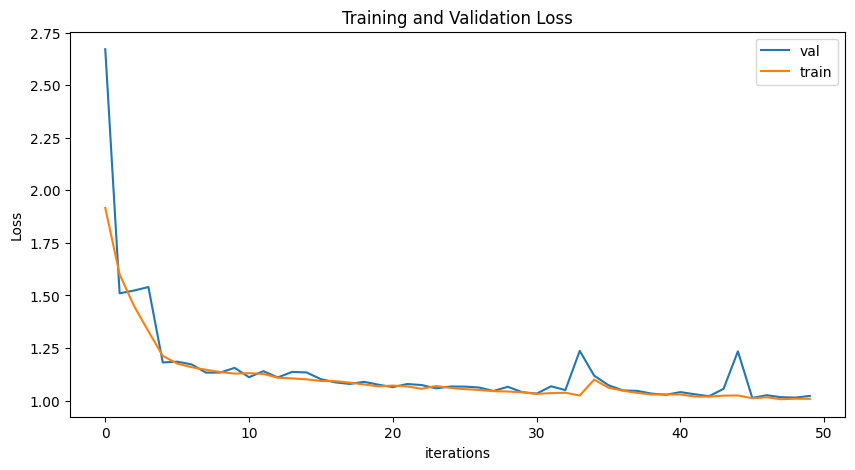

In [ ]:
import os
import sys
import math
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#from dataset import BrainTumorDataset
#from encoder.encoder_model import get_preprocessing_fn
#from Model import UNeT
#from model_training import train, evaluate
#from utils import save_figure


def main(model, preprocessing, device, width, height, learning_rate, weight_decay,  batch_size=8, num_epochs=50):
    train_dataset  = BrainTumorDataset(preprocessing_fun=preprocessing, image_size=(height, width))
    valida_dataset = BrainTumorDataset(train=False, preprocessing_fun=preprocessing, image_size=(height, width))
    print(len(train_dataset), len(valida_dataset))


    train_loader  = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader   = data.DataLoader(valida_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader), len(test_loader))


    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    best_model_loss = 1e10
    best_model_wts  = copy.deepcopy(model.state_dict())
    best_ssimScore = -1

    vald_losses = []
    train_losses = []

    for epoch in range(num_epochs):
        model, training_losss, train_ssim,train_psnr = train(model, train_loader, optimizer, device)
        model, val_losses, test_ssim ,test_psnr = evaluate(model, test_loader, device)
        vald_losses.append(val_losses)
        train_losses.append(training_losss)

        print(f'epoch {epoch} Training loss {training_losss} training ssim {train_ssim} training psnr {train_psnr} \
                  validation loss {val_losses} and testing ssim {test_ssim} testing_psnr {test_psnr}')

        if best_model_loss  > val_losses:
            best_model_loss = val_losses
            best_model_wts = copy.deepcopy(model.state_dict())
            best_ssimScore = test_ssim

        if epoch %50 ==0 :
            learning_rate = learning_rate /10

        save_figure(model, test_loader, epoch, device)
        torch.cuda.empty_cache()

    # print(f'Best validation loss {best_model_loss} and best ssim score {best_ssimScore}')
    # torch.save(best_model_wts.state_dict(), 'model_weights.pth')

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(vald_losses,label="val")
    plt.plot(train_losses,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    width = 640
    height = 640
    encoder_name= 'resnet18'
    learning_rate = 5e-4
    weight_decay = 1e-5
    batch_size = 8

    model = UNeT(encoder_name=encoder_name)
    model = model.to(device)
    preprocessing =  get_preprocessing_fn(encoder_name=encoder_name, pretrained='ssl')

    main(model, preprocessing=preprocessing, device=device, width=width, height=height,
                       learning_rate=learning_rate, weight_decay=weight_decay, batch_size=batch_size)

In [ ]:
train_dataset  = BrainTumorDataset(preprocessing_fun=preprocessing, image_size=(height, width))
valida_dataset = BrainTumorDataset(train=False, preprocessing_fun=preprocessing, image_size=(height, width))
print(len(train_dataset), len(valida_dataset))


train_loader  = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = data.DataLoader(valida_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

433 76
55 10


In [ ]:
def save_figure1(loader, num_epochs, device, mean = [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]):
    #model.eval()

    if not os.path.exists(os.path.join(os.getcwd(), 'save_results1')):
        os.mkdir(os.path.join(os.getcwd(), 'save_results1'))

    result_dir = os.path.join(os.getcwd(), 'save_results1')
    if not os.path.exists(os.path.join(result_dir, str(num_epoch))):
        os.mkdir(os.path.join(result_dir, str(num_epoch)))

    save_dir = os.path.join(result_dir, str(num_epoch))
    for idx, (x, y) in enumerate(loader):
        x = x.to(device).float()
        with torch.no_grad():
            out = torch.sigmoid(model(x))
            torchvision.utils.save_image(out[2,:], f"{save_dir}/pred_{idx}.png")
            torchvision.utils.save_image(y[2,:],  f"{save_dir}/target_{idx}.png")
            x = x.permute(0, 2, 3, 1).cpu().numpy()
            x = (x *np.array(std)) + np.array(mean)
            x = x / x.max()
            x = np.transpose(x, (0, 3, 1, 2))
            x = torch.from_numpy(x).float().to(device)
            torchvision.utils.save_image(x[2,:], f"{save_dir}/pnoisy_{idx}.png")
        break

In [ ]:
num_epoch = 50
save_figure1(test_loader, num_epoch, device)